# import libraries

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from pipetorch import DFrame
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
from scipy import stats
from seaborn import load_dataset, pairplot
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pipetorch.evaluate.study import Study, optuna
import time
from datetime import datetime, timezone
from sklearn.linear_model import Ridge


# data inladen

In [111]:
!ls /data/energie

001.xlsx  019.xlsx  037.xlsx  055.xlsx	073.xlsx  091.xlsx  109.xlsx
002.xlsx  020.xlsx  038.xlsx  056.xlsx	074.xlsx  092.xlsx  110.xlsx
003.xlsx  021.xlsx  039.xlsx  057.xlsx	075.xlsx  093.xlsx  111.xlsx
004.xlsx  022.xlsx  040.xlsx  058.xlsx	076.xlsx  094.xlsx  112.xlsx
005.xlsx  023.xlsx  041.xlsx  059.xlsx	077.xlsx  095.xlsx  113.xlsx
006.xlsx  024.xlsx  042.xlsx  060.xlsx	078.xlsx  096.xlsx  114.xlsx
007.xlsx  025.xlsx  043.xlsx  061.xlsx	079.xlsx  097.xlsx  115.xlsx
008.xlsx  026.xlsx  044.xlsx  062.xlsx	080.xlsx  098.xlsx  116.xlsx
009.xlsx  027.xlsx  045.xlsx  063.xlsx	081.xlsx  099.xlsx  117.xlsx
010.xlsx  028.xlsx  046.xlsx  064.xlsx	082.xlsx  100.xlsx  118.xlsx
011.xlsx  029.xlsx  047.xlsx  065.xlsx	083.xlsx  101.xlsx  119.xlsx
012.xlsx  030.xlsx  048.xlsx  066.xlsx	084.xlsx  102.xlsx  120.xlsx
013.xlsx  031.xlsx  049.xlsx  067.xlsx	085.xlsx  103.xlsx  unit_list.xlsx
014.xlsx  032.xlsx  050.xlsx  068.xlsx	086.xlsx  104.xlsx
015.xlsx  033.xlsx  051.xlsx  069.xlsx	087.xlsx  105

Wij willen de data van smartmeter en solar hebben. In elke dataset zijn er verschillende tabbladen. Wij moeten de sheetname bepalen tijdens het inladen van de huisjes.

In [162]:
data1= pd.read_excel('/data/energie/001.xlsx', sheet_name='smartMeter')
data2= pd.read_excel('/data/energie/001.xlsx', sheet_name='solar')

van timestamp een datum maken

In [163]:
data1['datum'] = [datetime.fromtimestamp(i) for i in data1['Timestamp']]
data1['datum'] = pd.to_datetime(data1['datum']).dt.date
data1= data1.drop_duplicates(subset='datum')
data1=data1.set_index('datum')
data1

,Timestamp,energy_in_low,energy_in_norm,energy_out_low,energy_out_norm,power,total_energy_in,total_energy_out
datum,,,,,,,,
2019-01-01,1546297473,911.438,1493.562,31.925,91.057,1573.5,2405.000,122.982
2019-01-02,1546383873,936.478,1493.562,32.134,91.057,95.1,2430.040,123.191
2019-01-03,1546470271,938.160,1508.769,32.134,91.504,92.7,2446.929,123.638
2019-01-04,1546556671,939.824,1531.635,32.134,92.988,92.3,2471.459,125.122
2019-01-05,1546643070,941.385,1556.682,32.134,92.989,91.7,2498.067,125.123
...,...,...,...,...,...,...,...,...
2019-12-28,1577487600,3191.204,4121.441,2019.177,4464.864,2433.0,7312.645,6484.041
2019-12-29,1577574000,3210.485,4121.441,2019.632,4464.864,960.0,7331.926,6484.496
2019-12-30,1577660401,3221.510,4121.441,2021.206,4464.864,166.0,7342.951,6486.070


In [164]:
data2['datum'] = [datetime.fromtimestamp(i) for i in data2['Timestamp']]
data2['datum'] = pd.to_datetime(data2['datum']).dt.date
data2= data2.drop_duplicates(subset='datum')
data2=data2.set_index('datum')
data2

,Timestamp,power,total_energy_in,total_energy_out
datum,,,,
2019-01-01,1546297471,2.385,3.37,329.83
2019-01-02,1546383871,2.390,3.42,332.67
2019-01-03,1546470270,2.427,3.48,335.54
2019-01-04,1546556671,2.411,3.54,341.00
2019-01-05,1546643070,2.331,3.61,341.73
...,...,...,...,...
2019-12-27,1577401200,2.540,19.44,8554.42
2019-12-28,1577487601,2.400,19.49,8562.04
2019-12-29,1577574000,2.420,19.55,8567.71


wij hebben een verslag van vorig jaar gekregen. Daarin stond hoe je het energieverbruik van een huis kunt berekenen. De formule is als volgt: energieverbruik= smart_in + solar_out - smart_out

om het energieverbruik te berekenen heb ik de koloomnamen veranderen en vervolgens smartmeter met solar gemergt

In [165]:
data1= data1[['total_energy_in', 'total_energy_out']]
data2= data2[['total_energy_in', 'total_energy_out']]
data1.columns = ['smart_in', 'smart_out']
data2.columns= ['solar_in', 'solar_out']

In [166]:
huis1= data1.merge(data2, on='datum', how='inner')

In [167]:
huis1['energie_verbruik']= huis1['smart_in'] + huis1['solar_out'] - huis1['smart_out']

In [168]:
huis1.isna().sum()

smart_in            0
smart_out           0
solar_in            0
solar_out           0
energie_verbruik    0
dtype: int64

# visualisatie huis1

<AxesSubplot:xlabel='datum'>

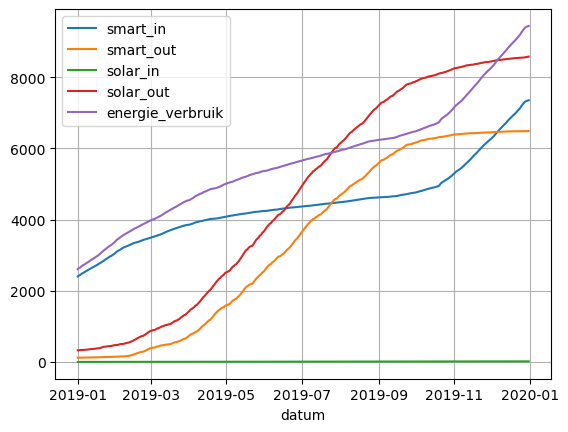

In [119]:
huis1.plot(grid=True)

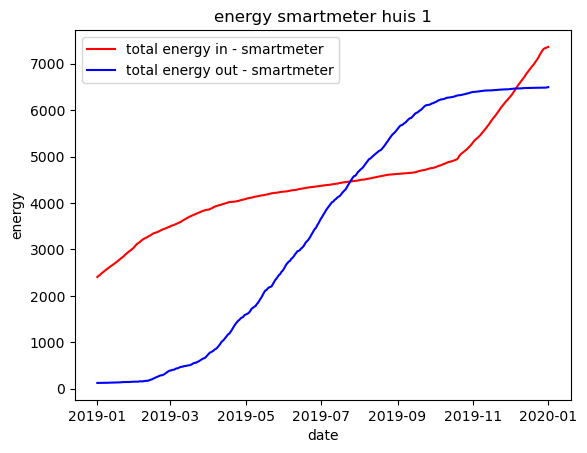

In [120]:
plt.plot(data1['smart_in'], color='r', label='total energy in - smartmeter')
plt.plot(data1['smart_out'], color='b', label='total energy out - smartmeter')
plt.xlabel('date')
plt.ylabel('energy')
plt.title('energy smartmeter huis 1')
plt.legend()

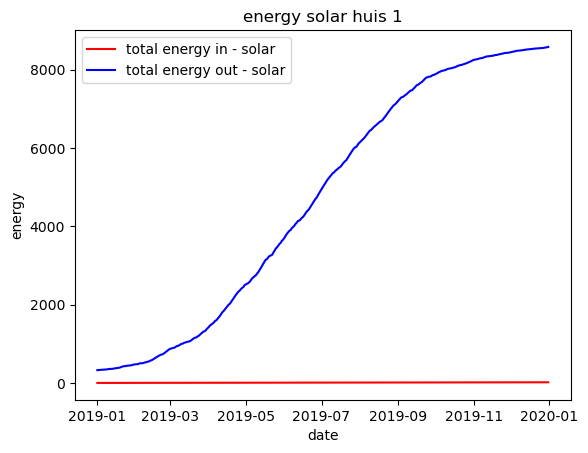

In [121]:
plt.plot(data2['solar_in'], color='r', label='total energy in - solar')
plt.plot(data2['solar_out'], color='b', label='total energy out - solar')
plt.xlabel('date')
plt.ylabel('energy')
plt.title('energy solar huis 1')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


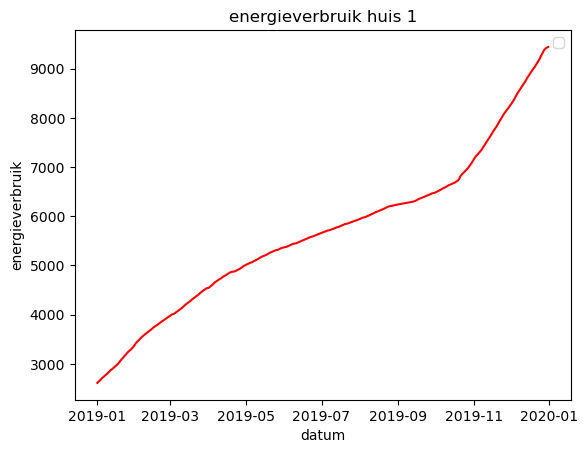

In [123]:
plt.plot(huis1['energie_verbruik'], color='r')
plt.xlabel('datum')
plt.ylabel('energieverbruik')
plt.title('energieverbruik huis 1')
plt.legend()

# energieverbruik stationaire maken

In [169]:
huis1['energie_verbruik_st']= huis1['energie_verbruik'].diff().fillna(0)

In [170]:
huis1

,smart_in,smart_out,solar_in,solar_out,energie_verbruik,energie_verbruik_st
datum,,,,,,
2019-01-01,2405.000,122.982,3.37,329.83,2611.848,0.000
2019-01-02,2430.040,123.191,3.42,332.67,2639.519,27.671
2019-01-03,2446.929,123.638,3.48,335.54,2658.831,19.312
2019-01-04,2471.459,125.122,3.54,341.00,2687.337,28.506
2019-01-05,2498.067,125.123,3.61,341.73,2714.674,27.337
...,...,...,...,...,...,...
2019-12-27,7276.278,6483.856,19.44,8554.42,9346.842,46.318
2019-12-28,7312.645,6484.041,19.49,8562.04,9390.644,43.802
2019-12-29,7331.926,6484.496,19.55,8567.71,9415.140,24.496


# visualisatie met stationaire verbruik

Text(0.5, 1.0, 'energieverbruik stationaire huis 1')

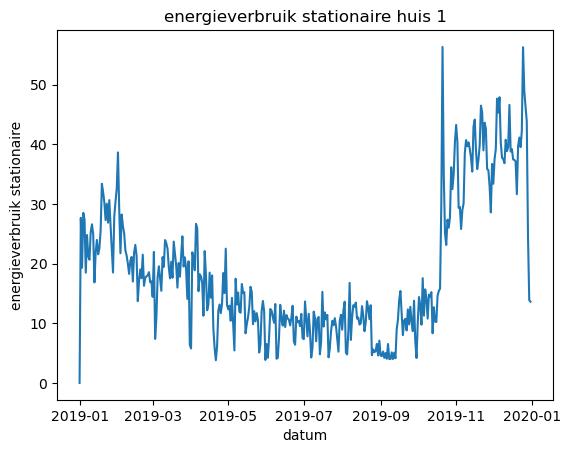

In [126]:
plt.plot(huis1['energie_verbruik_st'])
plt.xlabel('datum')
plt.ylabel('energieverbruik stationaire')
plt.title('energieverbruik stationaire huis 1')

# nieuwe kolommen aanmaken om straks als features te gebruiken

In [171]:
huis1.index = pd.to_datetime(huis1.index, errors='coerce')
huis1['datum']= huis1.index
huis1['maand'] = huis1['datum'].dt.strftime('%m')
huis1['dag']= [*range(1, len(huis1)+1)]

# weerdata inladen en met huis1 mergen

In [173]:
weer = pd.read_csv('KNMI.txt')
weer= weer[weer['YYYYMMDD'] >20181231]
weer= weer[weer['YYYYMMDD'] <20200101]
weer['datum'] = weer['YYYYMMDD'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
weer= weer[['datum', '    Q']]
weer.columns= ['datum', 'zonsterkte']
weer= weer.set_index('datum')
weer

,zonsterkte
datum,
2019-01-01,161
2019-01-02,147
2019-01-03,257
2019-01-04,49
2019-01-05,56
...,...
2019-12-27,334
2019-12-28,235
2019-12-29,199


In [175]:
huis1= huis1.drop(['datum'], axis=1)

In [177]:
huis1= huis1.merge(weer, on='datum', how='outer')
huis1

,smart_in,smart_out,solar_in,solar_out,energie_verbruik,energie_verbruik_st,maand,dag,zonsterkte
datum,,,,,,,,,
2019-01-01,2405.000,122.982,3.37,329.83,2611.848,0.000,01,1,161
2019-01-02,2430.040,123.191,3.42,332.67,2639.519,27.671,01,2,147
2019-01-03,2446.929,123.638,3.48,335.54,2658.831,19.312,01,3,257
2019-01-04,2471.459,125.122,3.54,341.00,2687.337,28.506,01,4,49
2019-01-05,2498.067,125.123,3.61,341.73,2714.674,27.337,01,5,56
...,...,...,...,...,...,...,...,...,...
2019-12-27,7276.278,6483.856,19.44,8554.42,9346.842,46.318,12,361,334
2019-12-28,7312.645,6484.041,19.49,8562.04,9390.644,43.802,12,362,235
2019-12-29,7331.926,6484.496,19.55,8567.71,9415.140,24.496,12,363,199


nu filter ik de dataset van huis1 en laat ik alleen de nodige kolommen staan

In [178]:
huis1= huis1[['dag', 'maand', 'zonsterkte', 'energie_verbruik', 'energie_verbruik_st']]

In [179]:
huis1

,dag,maand,zonsterkte,energie_verbruik,energie_verbruik_st
datum,,,,,
2019-01-01,1,01,161,2611.848,0.000
2019-01-02,2,01,147,2639.519,27.671
2019-01-03,3,01,257,2658.831,19.312
2019-01-04,4,01,49,2687.337,28.506
2019-01-05,5,01,56,2714.674,27.337
...,...,...,...,...,...
2019-12-27,361,12,334,9346.842,46.318
2019-12-28,362,12,235,9390.644,43.802
2019-12-29,363,12,199,9415.140,24.496


# detect outliers

<AxesSubplot:>

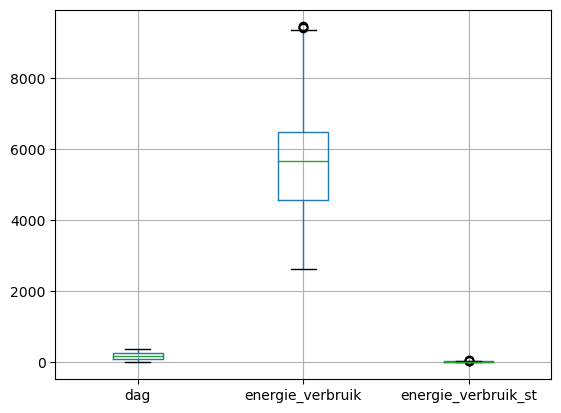

In [180]:
huis1.boxplot()

In [181]:
huis1['energie_verbruik'].std()

1602.6714419699108

In [190]:
huis1['energie_verbruik'].mean()

5677.82577260274

In [182]:
huis1['energie_verbruik'].max(), huis1['energie_verbruik'].min()

(9442.616, 2611.848)

In [189]:
max= np.percentile(huis1['energie_verbruik'], [99])

In [96]:
min= np.percentile(huis1['energie_verbruik'], [1])[0]

In [71]:
def remove_outliers(x):
    if(x>max):
        x= max
    elif(x<min):
        x=min
    return x